# Discrete-time LQ-optimal regulation (LQR) on a fixed time horizon with free final states

The goal is to find a sequence $\mathbf{u}_{0},\ldots,\mathbf{u}_{N-1}$ that yields the minimum in the following problem

\begin{align*}
\min_{\mathbf{x}_{1},\ldots,\mathbf{x}_{N},\mathbf{u}_{0},\ldots,\mathbf{u}_{N-1}} &\; \frac{1}{2}\mathbf x_N^T\mathbf S_N\mathbf x_N + \frac{1}{2}\sum_{k=0}^{N-1}\left[\mathbf x_k^T \mathbf Q \mathbf x_k+\mathbf u_k^T \mathbf R\mathbf u_k\right]\\
\text{s.t. } &\; \mathbf x_{k+1} = \mathbf A \mathbf x_{k} + \mathbf B \mathbf u_k,\\
& \mathbf x_0 = \mathbf r_0,\\
& \mathbf S_N\geq 0, \mathbf Q\geq 0, \mathbf R>0.
\end{align*}

We just remind the reader that the current formulation pushed the states towards the zero and for this control problem the terminology **regulation** is widely used (as opposed to **tracking** described elsewhere)

## Two-point boundary value problem

The necessary conditions of optimality come in the form of two recurrent equations (identical as in the fixed final state case)

\begin{align}
 \mathbf x_{k+1} &=\mathbf A\mathbf x_k-\mathbf B\mathbf R^{-1}\mathbf B^T\boldsymbol\lambda_{k+1},\\
 \boldsymbol\lambda_k &= \mathbf Q\mathbf x_k+\mathbf A^T\boldsymbol\lambda_{k+1}, 
\end{align}

together with the boundary conditions

\begin{align}
\mathbf S_N \mathbf x_N &= \boldsymbol \lambda_N,\\
\mathbf x_0 &= \mathbf r_0.
\end{align}

Once the sequence of states and costates is known, the optimal control sequence is obtained through

$$\mathbf u_k = -\mathbf R^{-1}\mathbf B^T\boldsymbol\lambda_{k+1},$$

which, of course, assumes nonsingularity of $\mathbf R$, but this was assumed in the very formulation of the optimal control problem above.

The above formulated two-point boundary value problem can be numerically tackled in a similar way as we approached its fixed final state counterpart, but we do not pursue it here. We leant the reason why attempting to solve the fixed final state problem - the underlying discrete-time Hamiltonian problem is numerically ill-conditioned. Instead, we focus on the idea of transforming the two-point boundary value problem into both conceptually and numerically much easier initial value problem. We describe it next. 

## Discrete-time (recurrent) Riccati equation

Upon solving the following (matrix) difference (or recurrent) equation

\begin{equation*}
 \mathbf S_k = \mathbf Q+\mathbf A^T\mathbf S_{k+1}(\mathbf I+\mathbf B\mathbf R^{-1}\mathbf B^T\mathbf S_{k+1})^{-1}\mathbf A
\end{equation*}

initialized with $\mathbf S_N$ at the end of the time interval [0,N], we can compute the optimal control through

\begin{equation*}
\mathbf u_k =\underbrace{(\mathbf R + \mathbf B^T\mathbf S_{k+1}\mathbf B)^{-1}\mathbf B^T\mathbf S_{k+1}\mathbf A}_{\mathbf K_k}\mathbf x_{k},
\end{equation*}


from which it is apparent that the optimal control sequence is actually generated through a time-varying state feedback (labelled $\mathbf K_k$).

Another - and numerically quite plausible - version of the iteration is

\begin{align}
 \mathbf K_k &= \left(\mathbf B^T \mathbf S_{k+1}\mathbf B+\mathbf R\right)^{-1}\mathbf B^T \mathbf S_{k+1}\mathbf A\\
 \mathbf S_k &= \mathbf A^T \mathbf S_{k+1}(\mathbf A-\mathbf B\mathbf K_k) + \mathbf Q.
\end{align} 

in which both $\mathbf S_k$ and $\mathbf K_k$ are solved in one iteration. This is the version we are going to implement.

In [1]:
function dre(A,B,Q,R,SN,N)
    nx = size(A,1)
    nu = size(B,2)
    S = [Matrix{Float64}(undef, nx, nx) for _ in 0:N]
    K = [Matrix{Float64}(undef, nu, nx) for _ in 0:N-1]
    S[end] = SN                # note that unlike in the mathematical formula, here the final time is at index N+1
    for k = N:-1:1
        K[k] = (R+B'*S[k+1]*B)\B'*S[k+1]*A
        S[k] = A'*S[k+1]*(A-B*K[k])+Q
    end
    return S,K
end

dre (generic function with 1 method)

In [2]:
A = [1.0 2; 3 4]
B = [5.0 6; 7 8]
Q = [1.0 0; 0 100]
R = [1.0 0; 0 1]
SN = [1.0 0; 0 100]
N = 30

30

In [3]:
S,K = dre(A,B,Q,R,SN,N);

We plot only some element, say, the (1,1) element of the $\mathbf S_k$ and $\mathbf K_k$ matrices below. The primary motivation is to see that if the time interval is long enough, they keep some constant value for most of the interval and only exhibit some changes towards the end of the inteval.

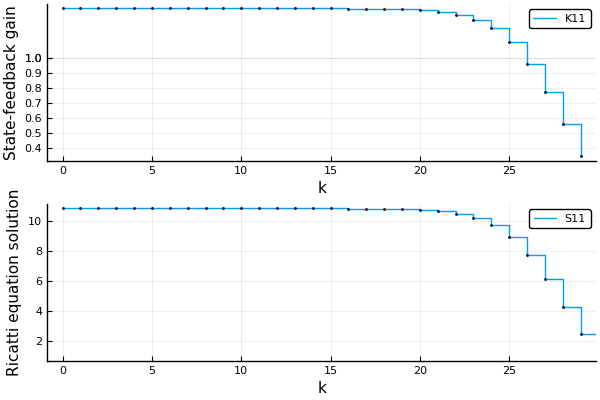

In [4]:
using Plots, LaTeXStrings
pyplot()
p1 = plot(0:1:(N-1),[K[i][1,1] for i=1:length(K)],xlabel="k",ylabel="State-feedback gain",label="K11",markershape=:circ,markersize=1,linetype=:steppost)
p2 = plot(0:1:N,[S[i][1,1] for i=1:length(S)],xlabel="k",ylabel="Ricatti equation solution",label="S11",markershape=:circ,markersize=1,linetype=:steppost,xlims=xlims(p1))
plot(p1,p2,layout=(2,1))

### Scalar case (first-order system)

Just in order to play a bit more conveniently with simple examples, let's consider scalar case of the full problem described and solved above.

In [5]:
function scalarDRE(a,b,q,r,sN,N)
    s = Vector{Float64}(undef,N+1)          # the S[1] will then not be needed (even defined) but the indices will fit
    k = Vector{Float64}(undef,N)
    s[end] = sN
    for i=N:-1:1
        k[i]=(a*b*s[i+1])/(r + s[i+1]*b^2);
        s[i]= a*s[i+1]*(a-b*k[i]) + q;
    end
    return s,k
end

scalarDRE (generic function with 1 method)

In [6]:
a = 1.05;
b = 0.01;
q = 1000;
r = 10;
x0 = 10;
sN = 50;
N = 50;

In [7]:
s,k = scalarDRE(a,b,q,r,sN,N);

We plot the computed solutions to the Riccati equation and also the time varying state-feedback (Kalman) gains. Note that we now label the time axes with `i` since the scalar gain is naturally labele with `k`.

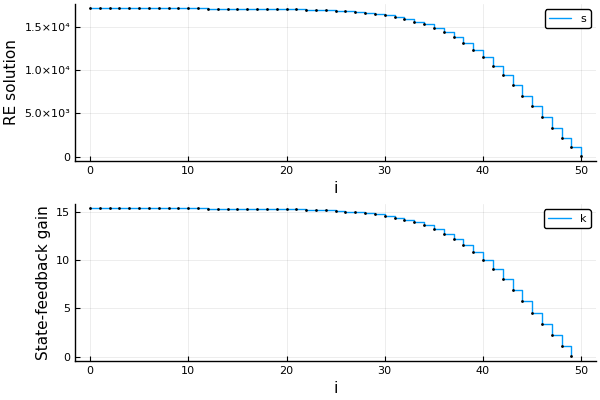

In [8]:
p1 = plot(0:1:N,s,xlabel="i",ylabel="RE solution",label="s",markershape=:circ,markersize=1,linetype=:steppost)
p2 = plot(0:1:N-1,k,xlabel="i",ylabel="State-feedback gain",label="k",markershape=:circ,markersize=1,linetype=:steppost,xlims=xlims(p1))
plot(p1,p2,layout=(2,1))

Now we are ready to simulate a response of a discrete-time system with the time-varying feedback gain

In [9]:
x = Vector{Float64}(undef,N+1)
u = Vector{Float64}(undef,N)

x[1]=x0;

for i=1:N
    u[i] = -k[i]*x[i];
    x[i+1] = a*x[i] + b*u[i];
end

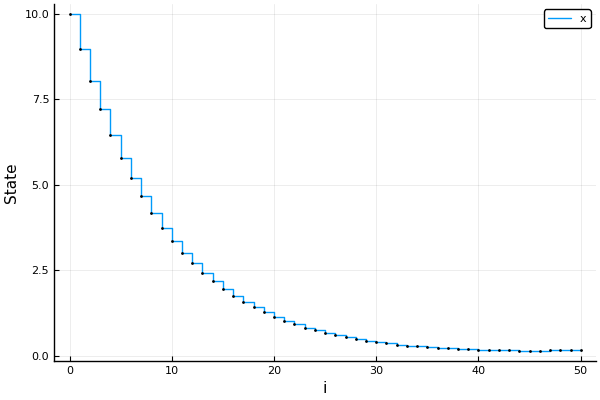

In [10]:
plot(0:1:N,x,xlabel="i",ylabel="State",label="x",markershape=:circ,markersize=1,linetype=:steppost)

## References

[1] Lewis, Frank, Draguna Vrabie, and Vassilis L. Syrmos. Optimal Control. 3rd edition. Hoboken: Wiley, 2012.

[2] Rawlings, James B., David Q. Mayne, and Moritz M. Diehl. Model Predictive Control: Theory, Computation, and Design. 2nd ed. Madison, Wisconsin: Nob Hill Publishing, LLC, 2017.